# **Data Preparation & Preprocessing**

## Import module

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, unicodedata, emoji
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from underthesea import word_tokenize

Set style for plot

In [37]:
sns.set_theme(style="whitegrid")

## Load & filter data

### Processing file

In [38]:
from typing import Any

def process_dataframe(df:dict[str, pd.DataFrame] | None, *process:Any):
    for key in df.keys():
        if process is None: continue
        for func in process:
            func(df, key)

In [39]:
def load_file(df:dict[str, pd.DataFrame], key:str):
    df[key] = pd.read_json(f'archive/UIT-VSFC-{key}.json')
    df[key] = df[key][(df[key]['topic'] == 'lecturer') & (df[key]['sentiment'] != 'neutral')].drop('topic', axis=1)
    df[key].reset_index(drop=True, inplace=True)
    print(f'{key.capitalize()} size: {df[key].shape}')
    display(df[key].head())

In [40]:
df = {
    'train': pd.DataFrame(),
    'dev': pd.DataFrame(),
    'test': pd.DataFrame()
}

try:
    process_dataframe(df, load_file)
except Exception as e:
    print(f"Errors: {e}")

Train size: (7980, 2)


,sentence,sentiment
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive


Dev size: (1119, 2)


,sentence,sentiment
0,giảng buồn ngủ .,negative
1,"giáo viên vui tính , tận tâm .",positive
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative


Test size: (2216, 2)


,sentence,sentiment
0,nói tiếng anh lưu loát .,positive
1,giáo viên rất vui tính .,positive
2,cô max có tâm .,positive
3,"giảng bài thu hút , dí dỏm .",positive
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative


### Label encoding

In [41]:
label_encoder = LabelEncoder()

df['train']['sentiment_encoded'] = label_encoder.fit_transform(df['train']['sentiment'])
df['dev']['sentiment_encoded'] = label_encoder.transform(df['dev']['sentiment'])
df['test']['sentiment_encoded'] = label_encoder.transform(df['test']['sentiment'])

for label, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded}")

print("Phân phối nhãn sau khi encode:")
print("Train:")
print(df['train']['sentiment_encoded'].value_counts().sort_index())
print("Dev:")
print(df['dev']['sentiment_encoded'].value_counts().sort_index())
print("Test:")
print(df['test']['sentiment_encoded'].value_counts().sort_index())

negative: 0
positive: 1
Phân phối nhãn sau khi encode:
Train:
sentiment_encoded
0    2909
1    5071
Name: count, dtype: int64
Dev:
sentiment_encoded
0    405
1    714
Name: count, dtype: int64
Test:
sentiment_encoded
0     791
1    1425
Name: count, dtype: int64


### EDA

Word cloud funtion

In [42]:
def getWordCloud(words):
    text = ' '.join(words)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    plt.figure()
    plt.show()

/tmp/ipykernel_4748/3645499780.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


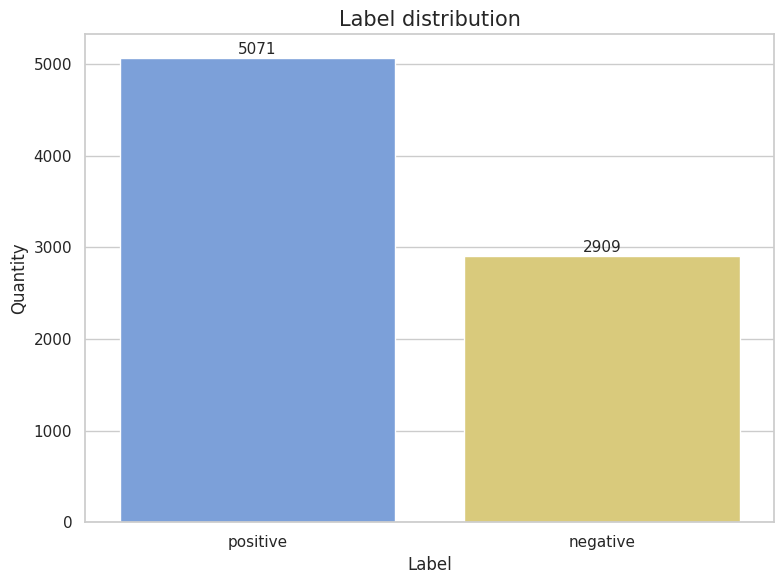

Quantity of each label:
positive: 5071 (63.55%)
negative: 2909 (36.45%)


In [43]:
sentiment_counts = df['train']['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    palette={'positive': '#6d9ce8', 'negative': '#e8d46d'}
)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Label distribution', fontsize=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

print("Quantity of each label:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count} ({count/len(df['train'])*100:.2f}%)")

/tmp/ipykernel_4748/1331689659.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


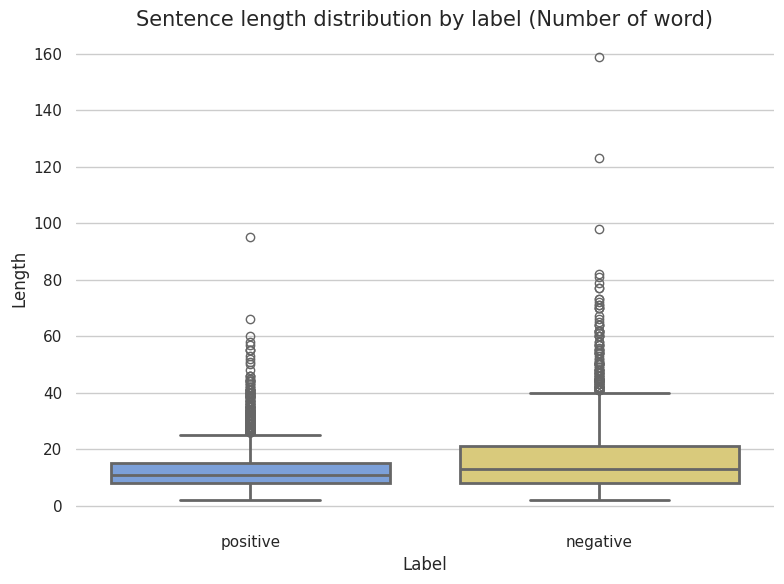

In [44]:
plt.figure(figsize=(8, 6))

df['train']['word_count'] = df['train']['sentence'].astype(str).apply(lambda x: len(x.split()))
ax = sns.boxplot(
    x='sentiment',
    y='word_count',
    data=df['train'],
    linewidth=2,
    palette={'positive': '#6d9ce8', 'negative': '#e8d46d'}
)

sns.despine(left=True, bottom=True)
ax.set_title('Sentence length distribution by label (Number of word)', fontsize=15)
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Length', fontsize=12)
plt.tight_layout()
plt.show()

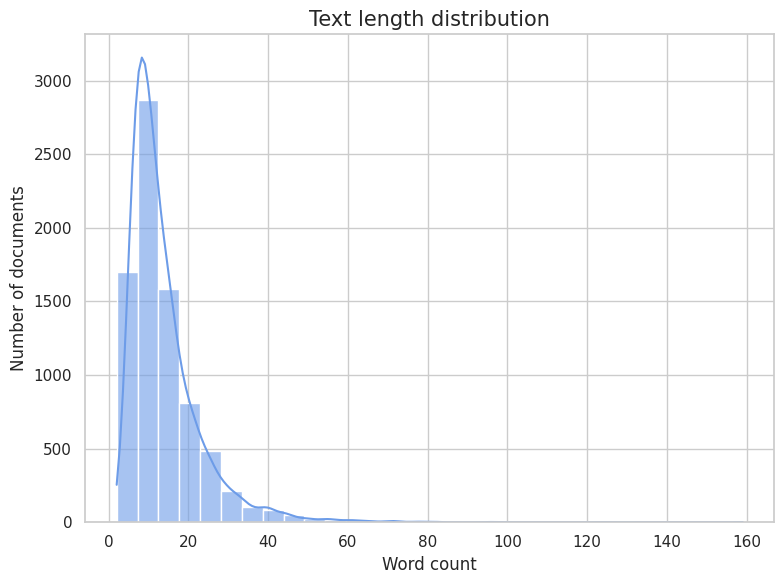

In [45]:
plt.figure(figsize=(8, 6))
sns.histplot(
    df['train']['word_count'],
    color='#6d9ce8',
    bins=30,
    alpha=0.6,
    kde=True
)
plt.title('Text length distribution', fontsize=15)
plt.xlabel('Word count', fontsize=12)
plt.ylabel('Number of documents', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


['positive', 'negative']
Label: positive


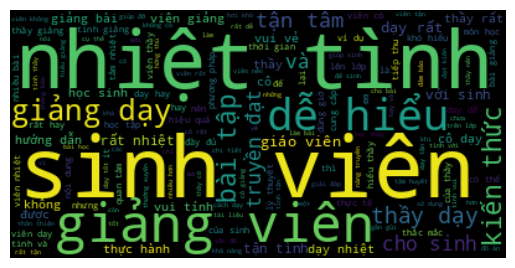

<Figure size 640x480 with 0 Axes>

Label: negative


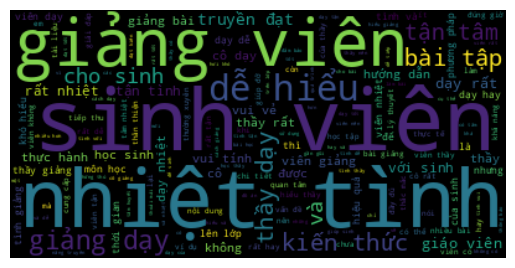

<Figure size 640x480 with 0 Axes>

In [47]:
labels = df['train']['sentiment'].value_counts().index.tolist()
print(labels)

for label in labels:
    print(f"Label: {label}")
    word_list = []

    for senc in df['train']['sentence']:
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)

    getWordCloud(word_list)

Note: Đang có rất nhiều stop-words cần phải xử lý cho 2 nhãn positive và negative

In [ ]:
stats_words = df['train'].groupby('sentiment')['word_count'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats_words.columns = ['Trung bình', 'Trung vị', 'Độ lệch chuẩn', 'Tối thiểu', 'Tối đa']

print("Thống kê số từ theo nhãn:")
display(stats_words)

Thống kê số từ theo nhãn:


,Trung bình,Trung vị,Độ lệch chuẩn,Tối thiểu,Tối đa
sentiment,,,,,
negative,16.37,13.0,11.77,2,159
positive,12.37,11.0,7.00,2,95


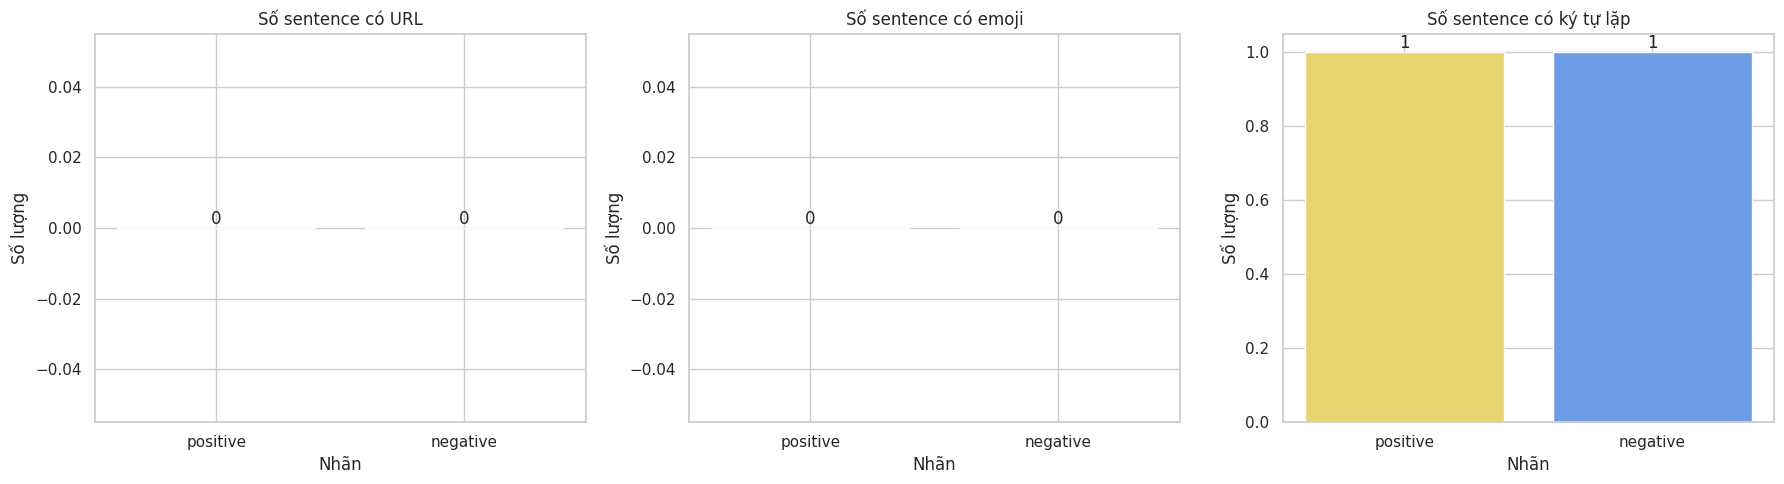

In [ ]:
def has_url(text):
    if not isinstance(text, str):
        return False

    url_pattern = r'https?://\S+|www\.\S+'
    return bool(re.search(url_pattern, text))

def has_emoji(text):
    if not isinstance(text, str):
        return False

    try:
        return emoji.emoji_count(text) > 0
    except:
        # Fallback: kiểm tra bằng regex pattern cho emoji
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        return bool(emoji_pattern.search(text))

def has_repeated_chars(text):
    if not isinstance(text, str):
        return False

    return bool(re.search(r'(.)\1{2,}', text))

# Không thêm cột! Xử lý và tổng hợp trên-the-fly
feature_funcs = [("URL", has_url), ("emoji", has_emoji), ("ký tự lặp", has_repeated_chars)]
special_features = {}
for label in df['train']['sentiment'].unique():
    mask = df['train']['sentiment'] == label
    sent_texts = df['train'].loc[mask, 'sentence']
    for feat_name, feat_func in feature_funcs:
        count = sent_texts.apply(feat_func).sum()
        special_features.setdefault(feat_name, {})[label] = count

special_features_df = pd.DataFrame(special_features).fillna(0).astype(int)
special_features_df = special_features_df.reindex(df['train']['sentiment'].unique())

# Visualize bằng bar chart mà không cần cột trong dataframe
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat_name, _) in enumerate(feature_funcs):
    feature_counts = special_features_df[feat_name]
    axes[idx].bar(feature_counts.index, feature_counts.values, color=sns.color_palette({'#6d9ce8', '#e8d46d'}, len(feature_counts)))
    axes[idx].set_title(f'Số sentence có {feat_name}')
    axes[idx].set_xlabel('Nhãn')
    axes[idx].set_ylabel('Số lượng')
    for i, v in enumerate(feature_counts.values):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Pre-processing text

Xử lý dấu câu

In [ ]:
def remove_punctuation(text:str) -> str:
    import string
    return text.translate(str.maketrans('', '', string.punctuation))

Stop words

In [ ]:
import requests

url_stop = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
path_stop = "archive/vietnamese-stopwords.txt"
path_sent = "archive/vietnamese-semtimentwords.txt"
stopwords = set(requests.get(url_stop).text.strip().replace(' ', '_').split('\n') + open(path_stop, 'r', encoding='utf-8').read().split('\n'))
sentwords = set(open(path_sent, 'r', encoding='utf-8').read().split('\n'))
stopwords = stopwords - sentwords

def normalize_stopwords(text:str):
    tokens = text.split()
    clean_tokens = [word for word in tokens if word not in stopwords]

    return ' '.join(clean_tokens)

Normalize unicode

In [ ]:
def normalize_unicode(text:str):
    return unicodedata.normalize('NFC', text)

Duplicate characters handling

In [ ]:
def remove_duplicate_characters(text:str):
    return re.sub(r'(.)\1+', r'\1', text)

Emoticon code handling

In [ ]:
def remove_specific_unnormalized(text:str):
    text = re.sub(r'wzjwz\d+', ' ', text)
    text = re.sub(r'colon\w+', ' ', text)
    text = re.sub(r'(doubledot)|(fraction)|(vdotv)', ' ', text)
    return text

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower().strip() # Lowercasing & Processing space
    text = normalize_unicode(text)
    text = remove_duplicate_characters(text)
    text = remove_punctuation(text)
    text = word_tokenize(text.lower(), format="text")
    text = normalize_stopwords(text)
    return text

Áp dụng các biện pháp xử lý

In [ ]:
df['train']["sentence_process"] = df['train']["sentence"].apply(preprocess_text)
df['dev']["sentence_process"] = df['dev']["sentence"].apply(preprocess_text)
df['test']["sentence_process"] = df['test']["sentence"].apply(preprocess_text)

display(df['train'].head())
display(df['dev'].head())
display(df['test'].head())

,sentence,sentiment,sentiment_encoded,word_count,sentence_process
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,1,11,nhiệt_tình gần_gũi
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative,0,18,chưa áp_dụng công_nghệ_thông_tin thiết_bị
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,1,15,hay có nhiều
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive,1,28,tích_cực trả_lời câu thường_xuyên câu
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive,1,11,rất tận_tình rất


,sentence,sentiment,sentiment_encoded,sentence_process
0,giảng buồn ngủ .,negative,0,buồn ngủ
1,"giáo viên vui tính , tận tâm .",positive,1,vui_tính tận_tâm
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative,0,nên giao nhiều hơn chia giảng_kỹ trọng_tâm hiệ...
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative,0,chi_tiết hơn đi_sâu hơn code chạy thử chương_t...
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative,0,nên có nước_ngoài có giao_tiếp


,sentence,sentiment,sentiment_encoded,sentence_process
0,nói tiếng anh lưu loát .,positive,1,tiếng lưu_loát
1,giáo viên rất vui tính .,positive,1,rất vui_tính
2,cô max có tâm .,positive,1,max có tâm
3,"giảng bài thu hút , dí dỏm .",positive,1,thu_hút dí dỏm
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative,0,không hướng_dẫn


### Sau tiền xử lý

Word Cloud

['positive', 'negative']
Label: positive


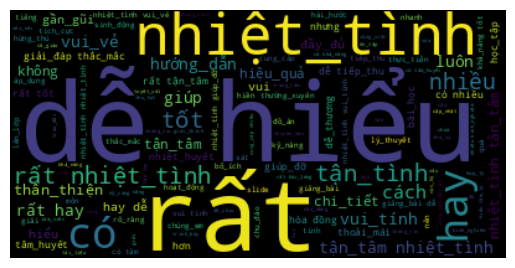

<Figure size 640x480 with 0 Axes>

Label: negative


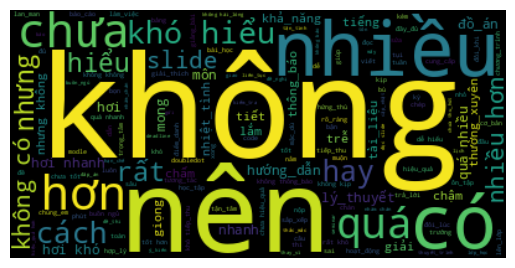

<Figure size 640x480 with 0 Axes>

In [ ]:
labels = df['train']['sentiment'].value_counts().index.tolist()
print(labels)

for label in labels:
    print(f"Label: {label}")
    word_list = []

    for senc in df['train'][df['train']['sentiment'] == label]['sentence_process']:
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)

    getWordCloud(word_list)

## Feature Extraction

TF-IDF vs N-grams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X_train = df['train']['sentence_process']
X_dev = df['dev']['sentence_process']
X_test = df['test']['sentence_process']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
print(f"Kích thước tập huấn luyện (Training Set): {X_train_tfidf.shape}")
print(f"Kích thước tập huấn luyện (Validation Set): {X_dev_tfidf.shape}")
print(f"Kích thước tập kiểm thử (Test Set): {X_test_tfidf.shape}")
print(f"Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: {X_train_tfidf.shape[1]}")

Kích thước tập huấn luyện (Training Set): (7980, 2600)
Kích thước tập huấn luyện (Validation Set): (1119, 2600)
Kích thước tập kiểm thử (Test Set): (2216, 2600)
Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: 2600


# **Training model**

## Import module

In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

Models configuration

In [ ]:
models = {
    'logistic regression':
        LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear',
            n_jobs=-1
        ),
    'naive bayes': MultinomialNB(),
    'linear-svm':
        LinearSVC(
            class_weight='balanced',
            max_iter=1000,
            dual=False
        )
}

## Evaluation

In [ ]:
y_train = df['train']['sentiment_encoded']
y_dev = df['dev']['sentiment_encoded']
y_test = df['test']['sentiment_encoded']

print(f"Train labels shape: {y_train.shape}")
print(f"Dev labels shape: {y_dev.shape}")
print(f"Test labels shape: {y_test.shape}")


Train labels shape: (7980,)
Dev labels shape: (1119,)
Test labels shape: (2216,)


### Train models

In [ ]:
# Dictionary to store trained models and results
trained_models = {}
results = {}

print("Training models...")

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Predictions
    y_train_pred = model.predict(X_train_tfidf)
    y_dev_pred = model.predict(X_dev_tfidf)
    y_test_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    results[name] = {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred, average='weighted'),
            'recall': recall_score(y_train, y_train_pred, average='weighted'),
            'f1': f1_score(y_train, y_train_pred, average='weighted')
        },
        'dev': {
            'accuracy': accuracy_score(y_dev, y_dev_pred),
            'precision': precision_score(y_dev, y_dev_pred, average='weighted'),
            'recall': recall_score(y_dev, y_dev_pred, average='weighted'),
            'f1': f1_score(y_dev, y_dev_pred, average='weighted')
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred, average='weighted'),
            'recall': recall_score(y_test, y_test_pred, average='weighted'),
            'f1': f1_score(y_test, y_test_pred, average='weighted')
        },
        'predictions': {
            'train': y_train_pred,
            'dev': y_dev_pred,
            'test': y_test_pred
        },
        'training_time': training_time
    }

print("All models trained successfully!")


Training models...

Training logistic regression...
Training completed in 0.01 seconds

Training naive bayes...
Training completed in 0.00 seconds

Training linear-svm...
Training completed in 0.01 seconds
All models trained successfully!


/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 22.
  warnings.warn(


### Results comparison

In [ ]:
# Create results DataFrame for comparison
comparison_data = []
for model_name, result in results.items():
    for dataset in ['train', 'dev', 'test']:
        comparison_data.append({
            'Model': model_name,
            'Dataset': dataset,
            'Accuracy': result[dataset]['accuracy'],
            'Precision': result[dataset]['precision'],
            'Recall': result[dataset]['recall'],
            'F1-Score': result[dataset]['f1']
        })

results_df = pd.DataFrame(comparison_data)
display(results_df)

,Model,Dataset,Accuracy,Precision,Recall,F1-Score
0,logistic regression,train,0.946742,0.947825,0.946742,0.946990
1,logistic regression,dev,0.935657,0.935916,0.935657,0.935758
2,logistic regression,test,0.913357,0.915928,0.913357,0.913990
3,naive bayes,train,0.941729,0.941600,0.941729,0.941635
4,naive bayes,dev,0.927614,0.927409,0.927614,0.927220
5,naive bayes,test,0.911552,0.911836,0.911552,0.911674
6,linear-svm,train,0.965414,0.965799,0.965414,0.965508
7,linear-svm,dev,0.941019,0.940863,0.941019,0.940889
8,linear-svm,test,0.914711,0.915790,0.914711,0.915062


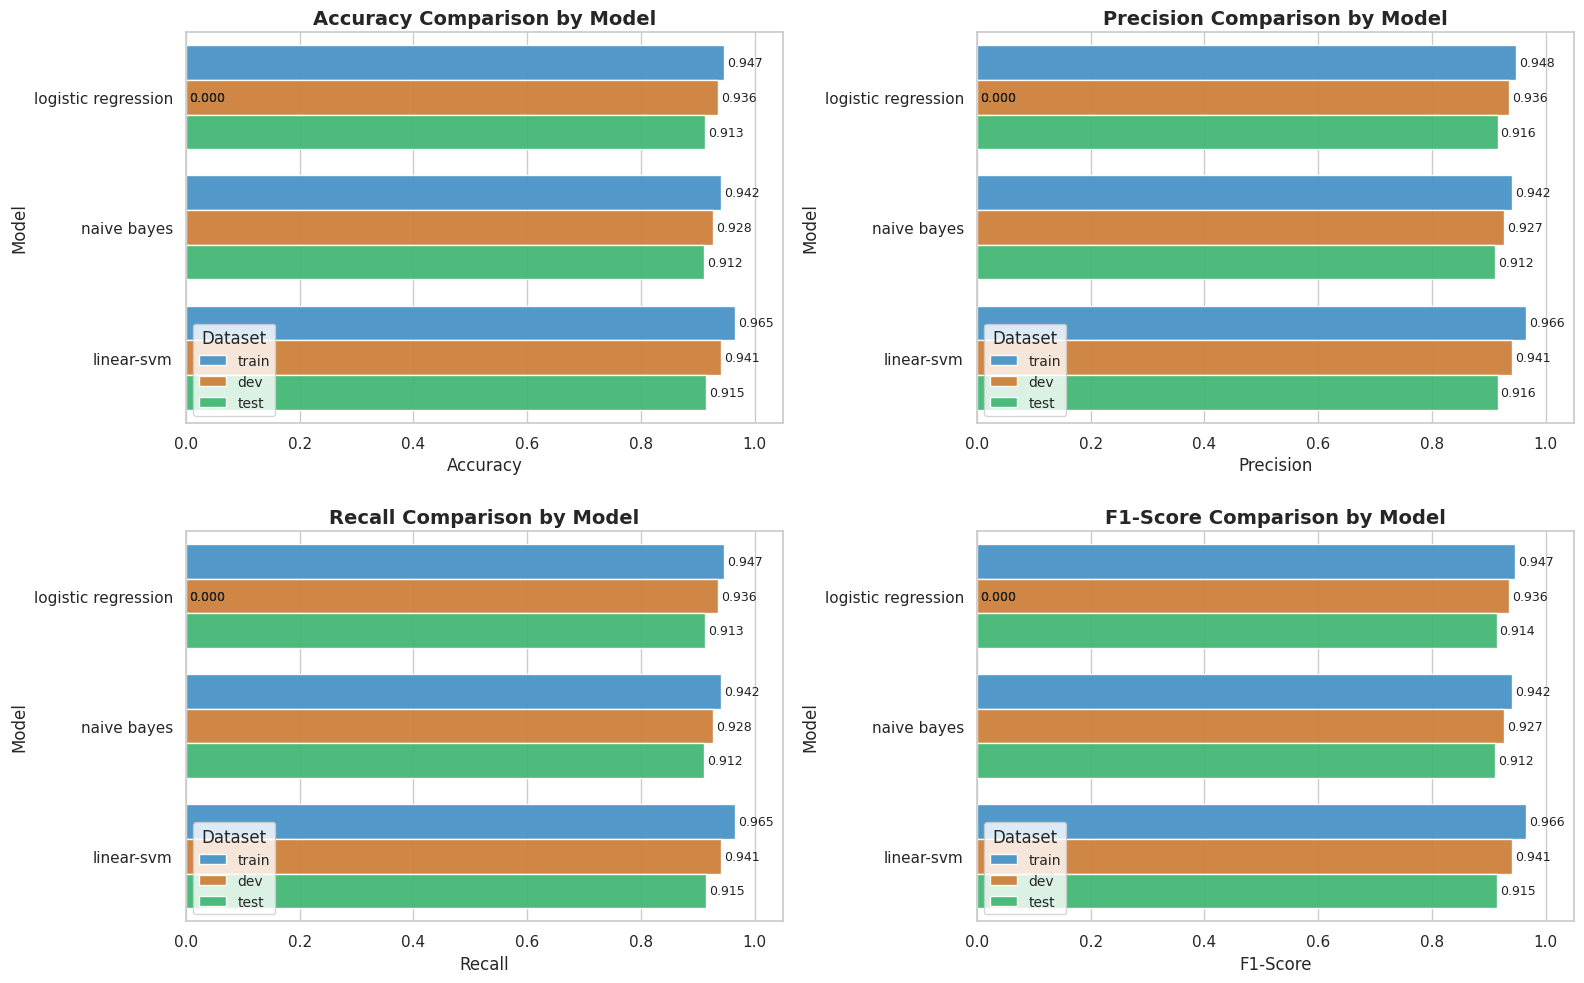

In [ ]:
# Visualize results in a more elegant way using seaborn

import seaborn as sns

sns.set_theme(style="whitegrid")
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

palette = {
    'train': '#3498db',
    'dev': '#e67e22',
    'test': '#2ecc71'
}

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sns.barplot(
        y=results_df['Model'],
        x=results_df[metric],
        hue=results_df['Dataset'],
        palette=palette,
        dodge=True,
        ax=ax,
        orient='h',
        alpha=0.95,
        edgecolor='w'
    )
    ax.set_xlabel(metric, fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    ax.set_title(f'{metric} Comparison by Model', fontsize=14, fontweight='bold')
    ax.legend(title='Dataset', fontsize=10, frameon=True)
    # Value label on bar
    for p in ax.patches:
        value = p.get_width()
        if not pd.isnull(value):
            ax.text(
                value + 0.005, 
                p.get_y() + p.get_height()/2, 
                f'{value:.3f}', 
                ha='left', va='center', fontsize=9, color='#222'
            )
    ax.set_xlim(0, 1.05)

plt.tight_layout(h_pad=2)
plt.show()


### Detailed classification reports

In [ ]:
for model_name in trained_models.keys():
    print(f"\n{'='*60}")
    print(f"Model: {model_name.upper()}")
    print(f"{'='*60}")
    
    for dataset_name, y_true, y_pred in [
        ('Train', y_train, results[model_name]['predictions']['train']),
        ('Dev', y_dev, results[model_name]['predictions']['dev']),
        ('Test', y_test, results[model_name]['predictions']['test'])
    ]:
        print(f"{dataset_name} Set Classification Report:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))


Model: LOGISTIC REGRESSION
Train Set Classification Report:
              precision    recall  f1-score   support

    negative     0.9077    0.9505    0.9286      2909
    positive     0.9708    0.9446    0.9575      5071

    accuracy                         0.9467      7980
   macro avg     0.9393    0.9475    0.9431      7980
weighted avg     0.9478    0.9467    0.9470      7980

Dev Set Classification Report:
              precision    recall  f1-score   support

    negative     0.9051    0.9185    0.9118       405
    positive     0.9534    0.9454    0.9494       714

    accuracy                         0.9357      1119
   macro avg     0.9292    0.9319    0.9306      1119
weighted avg     0.9359    0.9357    0.9358      1119

Test Set Classification Report:
              precision    recall  f1-score   support

    negative     0.8528    0.9153    0.8829       791
    positive     0.9510    0.9123    0.9312      1425

    accuracy                         0.9134      2216
   m

### Confusion matrices

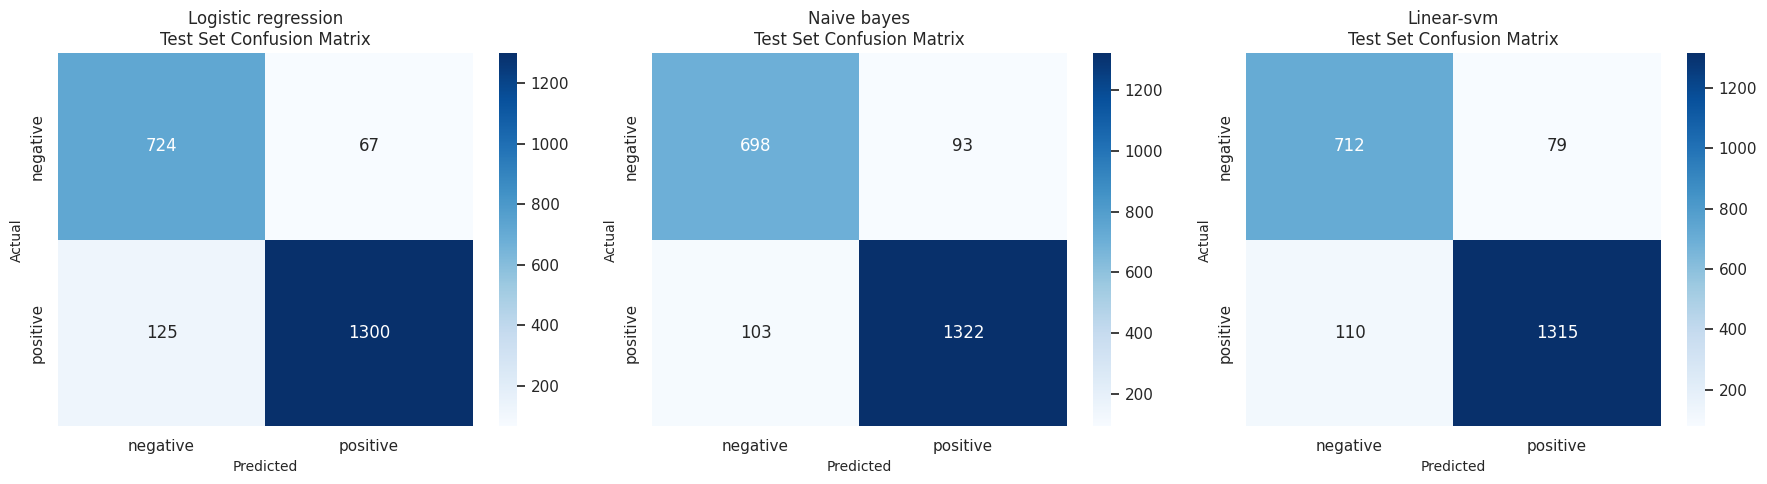

In [ ]:
# Plot confusion matrices for test set
fig, axes = plt.subplots(1, len(trained_models), figsize=(6*len(trained_models), 5))

if len(trained_models) == 1:
    axes = [axes]

for idx, (model_name, model) in enumerate(trained_models.items()):
    y_test_pred = results[model_name]['predictions']['test']
    cm = confusion_matrix(y_test, y_test_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    axes[idx].set_title(f'{model_name.capitalize()}\nTest Set Confusion Matrix', 
                        fontsize=12)
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.show()


### Best model selection

In [ ]:
# Find best model based on test F1-score
best_model_name = max(results.keys(), key=lambda x: results[x]['test']['f1'])
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name.upper()}")
print(f"Test F1-Score: {results[best_model_name]['test']['f1']:.4f}")
print(f"Test Accuracy: {results[best_model_name]['test']['accuracy']:.4f}")
print(f"Test Precision: {results[best_model_name]['test']['precision']:.4f}")
print(f"Test Recall: {results[best_model_name]['test']['recall']:.4f}")
print(f"Training Time: {results[best_model_name]['training_time']:.2f} seconds")

# Summary table for test set
test_summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['test']['accuracy'] for m in results.keys()],
    'Precision': [results[m]['test']['precision'] for m in results.keys()],
    'Recall': [results[m]['test']['recall'] for m in results.keys()],
    'F1-Score': [results[m]['test']['f1'] for m in results.keys()],
    'Training Time (s)': [results[m]['training_time'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print("\nTest Set Performance Summary (sorted by F1-Score):")
display(test_summary)


Best Model: LINEAR-SVM
Test F1-Score: 0.9151
Test Accuracy: 0.9147
Test Precision: 0.9158
Test Recall: 0.9147
Training Time: 0.01 seconds

Test Set Performance Summary (sorted by F1-Score):


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s)
2,linear-svm,0.914711,0.915790,0.914711,0.915062,0.012045
0,logistic regression,0.913357,0.915928,0.913357,0.913990,0.013788
1,naive bayes,0.911552,0.911836,0.911552,0.911674,0.003103


# **Testing với dữ liệu mới**

## Test với nhiều câu cùng lúc

In [ ]:
def predict_batch(texts, model_name=None):
    """
    Dự đoán sentiment cho nhiều câu cùng lúc.
    
    Parameters:
    -----------
    texts : list of str
        Danh sách các câu văn bản cần dự đoán
    model_name : str, optional
        Tên mô hình để sử dụng. Nếu None, sử dụng best_model
    
    Returns:
    --------
    pd.DataFrame : DataFrame chứa kết quả dự đoán
    """
    # Sử dụng best model nếu không chỉ định
    if model_name is None:
        model = best_model
        model_name = best_model_name
    else:
        if model_name not in trained_models:
            raise ValueError(f"Model '{model_name}' not found. Available models: {list(trained_models.keys())}")
        model = trained_models[model_name]
    
    # Tiền xử lý
    processed_texts = [preprocess_text(text) for text in texts]
    
    # Vectorize
    texts_vectorized = tfidf_vectorizer.transform(processed_texts)
    
    # Dự đoán
    predictions = model.predict(texts_vectorized)
    sentiment_labels = label_encoder.inverse_transform(predictions)
    
    # Lấy xác suất nếu có
    probabilities = None
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(texts_vectorized)
    elif hasattr(model, 'decision_function'):
        decisions = model.decision_function(texts_vectorized)
        probabilities = []
        for decision in decisions:
            proba_dict = {
                0: max(0, -decision / 2 + 0.5),
                1: min(1, decision / 2 + 0.5)
            }
            total = sum(proba_dict.values())
            proba_dict = {k: v/total for k, v in proba_dict.items()}
            probabilities.append([proba_dict[0], proba_dict[1]])
        probabilities = np.array(probabilities)
    
    # Tạo DataFrame kết quả
    results = pd.DataFrame({
        'Text': texts,
        'Processed Text': processed_texts,
        'Predicted Sentiment': sentiment_labels,
        'Model': model_name
    })
    
    # Thêm xác suất nếu có
    if probabilities is not None:
        for idx, label in enumerate(label_encoder.classes_):
            results[f'Probability_{label}'] = probabilities[:, idx]
    
    return results

# Ví dụ test với nhiều câu
batch_texts = [
    "Giảng viên rất nhiệt tình và có phương pháp giảng dạy tốt",
    "Thầy cô không quan tâm đến học sinh",
    "Bài giảng rất hay và dễ hiểu",
    "Giảng viên thường xuyên đi muộn",
    "Cô giáo rất vui tính và tạo không khí học tập tích cực"
]

print("Testing với nhiều câu cùng lúc:\n")
batch_results = predict_batch(batch_texts)
display(batch_results)


Testing với nhiều câu cùng lúc:



,Text,Processed Text,Predicted Sentiment,Model,Probability_negative,Probability_positive
0,Giảng viên rất nhiệt tình và có phương pháp gi...,rất nhiệt_tình có tốt,positive,linear-svm,0.000000,1.000000
1,Thầy cô không quan tâm đến học sinh,thầy_cô không,negative,linear-svm,1.093386,-0.093386
2,Bài giảng rất hay và dễ hiểu,rất hay dễ hiểu,positive,linear-svm,0.000000,1.000000
3,Giảng viên thường xuyên đi muộn,thường_xuyên muộn,negative,linear-svm,0.934413,0.065587
4,Cô giáo rất vui tính và tạo không khí học tập ...,cô_giáo rất vui_tính không_khí học_tập tích_cực,positive,linear-svm,0.000000,1.000000
